In [3]:
import timm
import torch
from PIL import Image
import numpy as np

# %load "../segmentation.py"
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
model = timm.create_model("vit_base_patch32_224", num_classes=116)

In [3]:
trained_model = torch.load("../models/vit_base_patch32_224.pt", map_location=torch.device("cpu"))

In [4]:
model.load_state_dict(trained_model["model_state_dict"])

<All keys matched successfully>

In [5]:
with open("../labels.txt") as f:
    prod = []
    for line in f.readlines():
        prod.append(line)

In [4]:
def infer(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      return prod[index].strip(), output

def infer_video(frame,model):
   frame = frame[256:812,512:1216,]
   img = Image.fromarray(np.uint8(frame)).convert('RGB')
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      return output.max(), frame, frame.mean()

def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [5]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [6]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 1799/1799 [01:26<00:00, 20.69it/s]


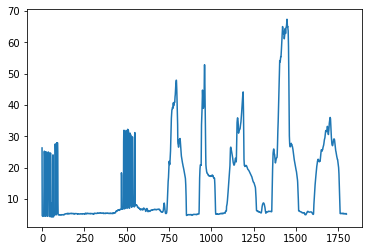

In [7]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

video_location = "../test-videos/"
videos = ["testA_1.mp4"]
images_list = []
ratios_list = []
colors_list = []
metrics_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []
  colors = []
  metrics = []
  for img in resized_image:
    # ratio = get_ratio(img)
    color = image_colorfulness(img)
    # metric = color*color*ratio
    colors.append(color)
    # ratios.append(ratio)
    # metrics.append(metric)
  
  images_list.append(resized_image)
  # ratios_list.append(ratios)
  colors_list.append(colors)
  # metrics_list.append(metrics)
  # print(video)
  # plt.plot(metrics)
  # plt.show()
  # plt.plot(ratios)
  # plt.show()
  plt.plot(colors)
  plt.show()

In [8]:
import scipy.fftpack as fftpack

def get_sharpness(image):
    im = Image.fromarray(image).convert('L') # to grayscale
    array = np.asarray(im, dtype=np.int32)

    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

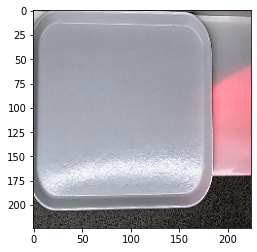

Color 8.167794706454442
Sharp 7.758936635912827
Metric 113.23455961031982


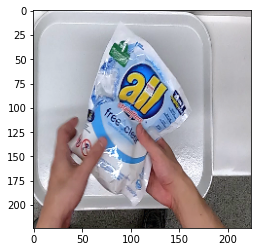

Color 29.13930656799327
Sharp 5.359846038024125
Metric 220.0345393418451


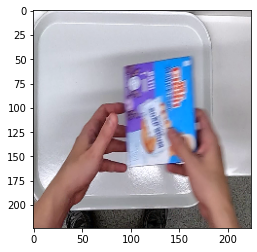

Color 17.37923845777346
Sharp 6.157916597694609
Metric 303.1054478990398


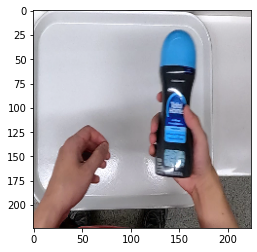

Color 20.703031847212078
Sharp 5.803714095366864
Metric 214.80745169196868


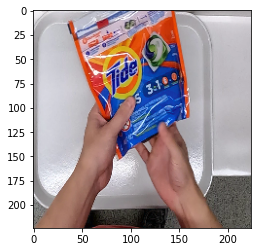

Color 66.53294263546601
Sharp 10.862756221967894
Metric 401.5351879464278


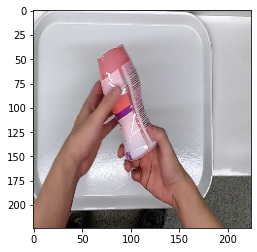

Color 27.788495129810283
Sharp 4.558660953067654
Metric 178.2558377704663


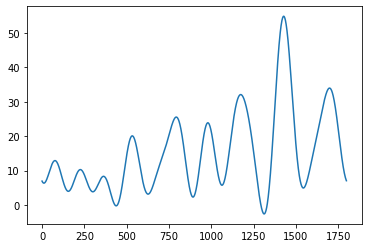

NEXT


In [11]:
from scipy.signal import savgol_filter, argrelextrema,find_peaks
import math
images_with_object = []
idx = []
count = 1
for images, colors in zip(images_list, colors_list):
    frames_with_object = []
    rolling_colors = smooth_data_fft(colors, 20)
    maximas = find_peaks(rolling_colors)
    for maxima in maximas[0]:
        candidate_frame = maxima
        max_sharpness = -1
        max_metric = -1
        for i in range(-21,22,7):
            current_frame = maxima+i
            if(current_frame>=len(images)):
                continue
            sharpness = get_sharpness(images[current_frame])
            colorfulness = image_colorfulness(images[current_frame])
            ratio = get_ratio(images[current_frame])
            metric = colorfulness*colorfulness * ratio
            metric = math.sqrt(metric)
            if(sharpness>max_sharpness and metric>max_metric):
                max_sharpness = sharpness
                max_metric = metric
                candidate_frame = current_frame
        if(max_metric>110):
            frames_with_object.append((images[candidate_frame],candidate_frame))
            idx.append(candidate_frame)
            count+=1
            plt.imshow(images[candidate_frame][:,:,[2,1,0]])
            plt.show()

            print(f"Color {colorfulness}")
            print(f"Sharp {sharpness}")
            print(f"Metric {max_metric}")

    plt.plot(rolling_colors)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)

In [12]:
idx

[547, 779, 959, 1181, 1434, 1677]

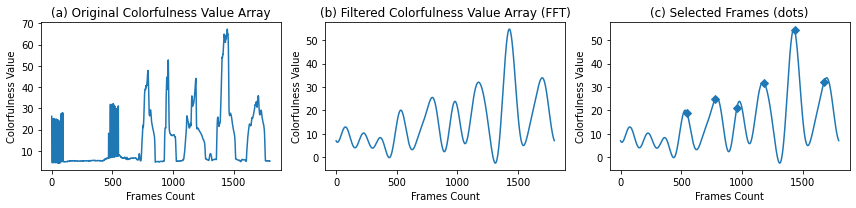

In [23]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(colors)
plt.xlabel("Frames Count")
plt.ylabel("Colorfulness Value")
plt.title("(a) Original Colorfulness Value Array")
plt.subplot(132)
plt.plot(rolling_colors)
plt.xlabel("Frames Count")
plt.ylabel("Colorfulness Value")
plt.title("(b) Filtered Colorfulness Value Array (FFT)")
plt.subplot(133)
plt.plot(rolling_colors,"-D", markevery=idx)
plt.xlabel("Frames Count")
plt.ylabel("Colorfulness Value")
plt.title("(c) Selected Frames (dots)")
plt.tight_layout()
plt.savefig("colorfulness-fft.png",dpi=300)
plt.show()

In [16]:
model_path = '../models/unet_aicityt4.pth'

import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
######################################################################################### 

# Define model
segmentation_model = build_unet()
checkpoint = torch.load(model_path, map_location="cpu")
segmentation_model.load_state_dict(checkpoint)
# Send to GPU
segmentation_model = segmentation_model.to(DEVICE)
segmentation_model.eval()

def visualize(idx, **images):
    """Plot images in one row.""" 
    n = len(images)
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).lower(), fontsize=20)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        plt.show()

        #plt.tight_layout()
    #plt.savefig("../outputs/vis/compare-segs/{}.png".format(idx), facecolor="white", bbox_inches = 'tight')


In [17]:
#To use this block, run `pip install pytorch-lightning`
#Reference: https://github.com/guglielmocamporese/hands-segmentation-pytorch

# Imports
import torch
import torch.hub

# Create the model
hand_seg_model = torch.hub.load(
    repo_or_dir='guglielmocamporese/hands-segmentation-pytorch', 
    model='hand_segmentor', 
    pretrained=True
)
hand_seg_model.eval()

Using cache found in /home/istiak_admin/.cache/torch/hub/guglielmocamporese_hands-segmentation-pytorch_master
Downloading...
From: https://drive.google.com/uc?id=1w7dztGAsPHD_fl_Kv_a8qHL4eW92rlQg
To: /home/istiak_admin/Codes/classification-pipeline-2/notebooks/checkpoint/checkpoint.ckpt
100%|██████████| 476M/476M [02:46<00:00, 2.86MB/s] 


HandSegModel(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [42]:
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters.rank import entropy
from skimage.morphology import disk

transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.CenterCrop((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


def crop_with_hand_seg(img):
    """
    Crops product image using product and hand segmentation.
    """
    image_b = torch.unsqueeze(img, 0)
    image = (image_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    pred = hand_seg_model(image_b).argmax(1).detach().cpu().numpy().squeeze()
    # invert mask, use plt.imshow(hand_pred) for vis
    hand_pred = np.logical_not(pred).astype(int) 
    
    # Stack preds for getting ROI
    hand_pred3d = np.stack((hand_pred, hand_pred, hand_pred), axis=-1)
    # Get rid off hands
    image_no_hands = np.array(image) * hand_pred3d # use plt.imshow(image_no_hands) for vis
    
    # Convert new image to tensor
    image_no_hands = Image.fromarray(np.uint8(image_no_hands)).convert('RGB')
    image_tensor = transforms_image(image_no_hands)

    image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    # Image ROI
    image_roi = image_no_hands * mask
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data

def crop_without_hand_seg(img):
    """
    Crops product image using product segmentation.
    """
    image_tensor_b = torch.unsqueeze(img, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image = (image_tensor_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    image_roi = image * mask
    
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data


def entropy_based_seg(img):
    image_gray = rgb2gray(img)
    image_gray = img_as_ubyte(image_gray)
    entropy_image = entropy(image_gray, disk(6)) # 6 default
    scaled_entropy = entropy_image / entropy_image.max()
    threshold = scaled_entropy > 0.8 # 0.8 default
    image_seg = np.dstack([img[:,:,0]*threshold,
                            img[:,:,1]*threshold,
                            img[:,:,2]*threshold])
    return image_seg


def crop_with_hand_entropy_seg(img):
    """
    Crops product image using product, hand and entropy based segmentation.
    
    Reference: https://towardsdatascience.com/image-processing-with-python-working-with-entropy-b05e9c84fc36
    """
        
    image_b = torch.unsqueeze(img, 0).to(DEVICE)
    image = (image_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    pred = hand_seg_model(image_b).argmax(1).detach().cpu().numpy().squeeze()
    # invert mask, use plt.imshow(hand_pred) for vis
    hand_pred = np.logical_not(pred).astype(int) 
    
    # Stack preds for getting ROI
    hand_pred3d = np.stack((hand_pred, hand_pred, hand_pred), axis=-1)
    # Get rid off hands
    image_no_hands = np.array(image) * hand_pred3d # use plt.imshow(image_no_hands) for vis
    
    # Convert new image to tensor
    image_no_hands = Image.fromarray(np.uint8(image_no_hands)).convert('RGB')
    image_tensor = transforms_image(image_no_hands)

    image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image_roi = image_no_hands * mask
    
    image_roi = entropy_based_seg(image_roi)
    
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data


In [94]:
def get_blobs(image):
    img = np.array(image)

    # Convert you image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Threshold the image to extract only objects that are not black
    # You need to use a one channel image, that's why the slice to get the first layer
    tv, thresh = cv2.threshold(gray[:,:,0], 1, 255, cv2.THRESH_BINARY)

    # Get the contours from your thresholded image
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # Create a copy of the original image to display the output rectangles
    output = img.copy()

    # Loop through your contours calculating the bounding rectangles and plotting them
    # for c in contours:
    #     x, y, w, h = cv2.boundingRect(c)
        # if(w*h>(224*244)/10):
    c = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    return x,y,w,h
    # cv2.rectangle(output, (x,y), (x+w, y+h), (0, 0, 255), 2)
    # # Display the output image
    # plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    # plt.show()

In [100]:

transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.CenterCrop((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



def preprocess_image_classification(frame):
   img = Image.fromarray(frame).convert('RGB')

   mean = [0.4124, 0.3856, 0.3493] 
   std = [0.2798, 0.2703, 0.2726]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   return img_normalized

def infer_frame(frame, model):
   img = Image.fromarray(frame).convert('RGB')
   img = transforms_image(img)
   segmented_image = crop_with_hand_entropy_seg(img)["roi"]
   x,y,w,h = get_blobs(segmented_image)
   image_roi = frame[y:y+h, x:x+w]
   plt.imshow(image_roi[:,:,[2,1,0]])
   plt.show()
   img_normalized = preprocess_image_classification(frame=image_roi[:,:,[2,1,0]])
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      op_array = output.data.cpu().numpy()
      print(op_array[0][index])
      return index+1


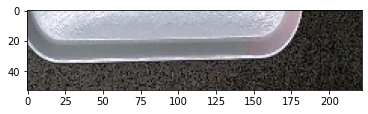

8.169646
Flow Flex Covid 19 Test,42



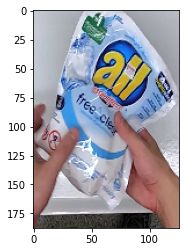

12.866882
All Free and Clear Pods,6



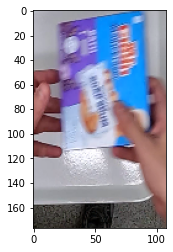

7.7446094
Mr Clean,76



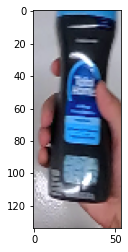

8.081567
Total Home Scent Boos,106



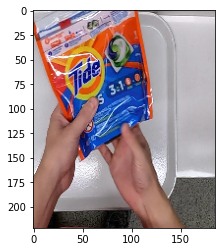

13.598817
Tide Pods,103



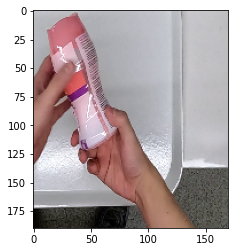

7.6088862
Dreft Scent Beads,37



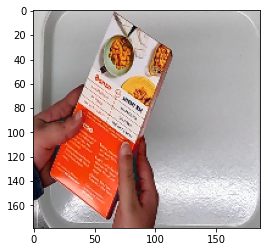

11.019187
Banza,9



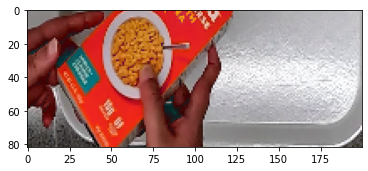

9.1033
Banza,9



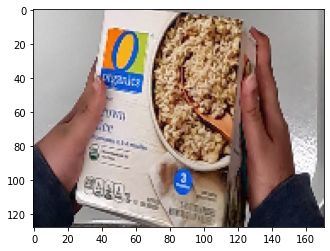

13.412455
Brown Rice,18



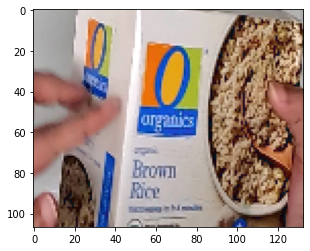

13.871696
Brown Rice,18



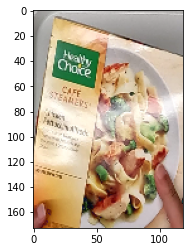

11.470601
Healthy Choice Chicken Alfredo,54



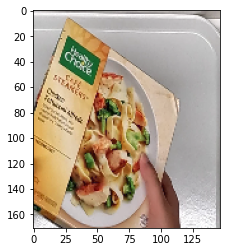

10.451207
Healthy Choice Chicken Alfredo,54



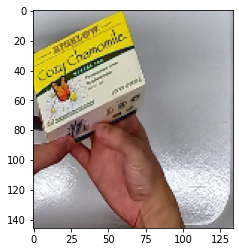

9.038723
Chamomile Tea,21



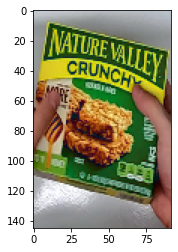

11.601704
Nature Valley Granola Bars,80



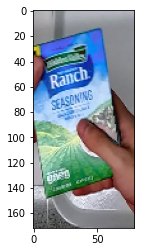

11.211716
Ranch Seasoning,91



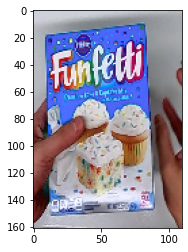

12.098654
Funfetti Cake,46



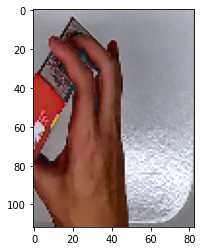

4.5709176
Strawberry Jello,98



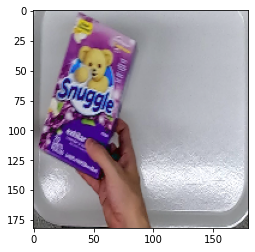

8.908146
Snuggle Dryer Sheets,95



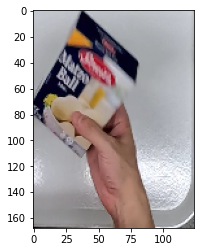

9.535739
Matzo Balls,67



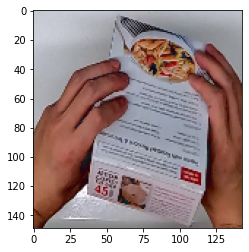

8.911048
Gluten Free Pasta,52



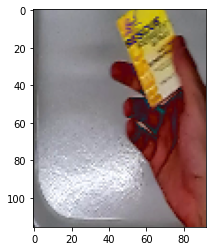

6.2912655
Mochi Ice Cream,74



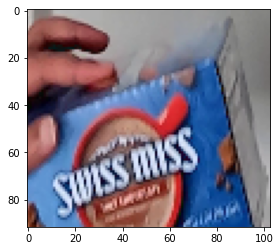

9.866495
Swiss Miss Hot Chocolate,101



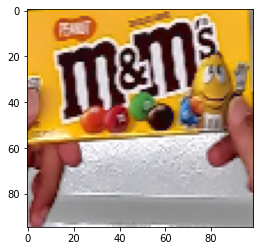

9.690404
M&Ms Peanuts,73



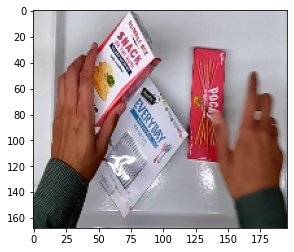

7.0173516
McCormick Natures Food Coloring,68



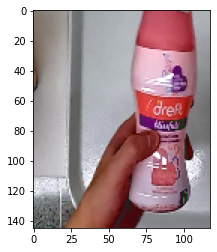

10.319594
Dreft Scent Beads,37



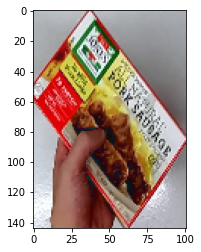

13.736377
Pork Sausage,88



In [101]:

video_id = []
object_id = []
timestamp = []
for idx in range(len(images_with_object)):
    lastoutput = ""
    for image,frame in images_with_object[idx]:
        output = infer_frame(image, model)
        lastoutput=output
        video_id.append(idx+1)
        object_id.append(output)
        print(prod[output-1])
        timestamp.append(int(frame/60))    

In [109]:
with open('vit_duplication_removed.txt', 'w') as f:

    prev_vid = -1
    prev_obj = -1
    for vid, obj, tim in zip(video_id, object_id, timestamp):
        if(vid==prev_vid and obj==prev_obj):
            continue
        f.write(f'{vid} {obj} {tim}\n')
        prev_vid = vid
        prev_obj = obj
    f.close()